# Vaccinazioni

Vaccinazioni in Italia.

> Max Pierini

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from IPython.display import Markdown

In [2]:
cov = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale-latest.csv',
    parse_dates=['data']
)

In [3]:
tot = cov.totale_casi.values[0]

In [4]:
pop = pd.read_csv('pop_16.csv')

In [12]:
smr = pd.read_csv(
    'https://github.com/italia/covid19-opendata-vaccini/raw/master/dati/anagrafica-vaccini-summary-latest.csv',
    parse_dates=['ultimo_aggiornamento']
)

In [5]:
eta = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_fasceEta.csv',
    parse_dates=['aggiornamento'],
)

In [6]:
sex = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_sesso.csv',
    parse_dates=['aggiornamento'],
)

In [7]:
cat = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_categoria.csv',
    parse_dates=['aggiornamento'],
)

In [8]:
cat['cat_idx'] = cat.categoria.str.replace('.* - ', '').str.replace(' ', '\n')

In [9]:
reg = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/latest_somministrazioni.csv',
    parse_dates=['aggiornamento'],
)

# Ultimi dati

In [28]:
smr_melt = pd.DataFrame(smr.sum()).T.melt()

In [45]:
smr_cat = smr_melt[smr_melt.variable.str.contains('categoria')].copy(deep='True')

In [46]:
smr_cat['variable'] = smr_cat.variable.str.replace('categoria_', '')

In [48]:
smr_cat['variable'] = smr_cat.variable.str.replace('_sociosanitari', '')

In [50]:
smr_cat['variable'] = smr_cat.variable.str.replace('personale_', '')

In [58]:
smr

,fascia_anagrafica,totale,sesso_maschile,sesso_femminile,categoria_operatori_sanitari_sociosanitari,categoria_personale_non_sanitario,categoria_ospiti_rsa,categoria_over80,prima_dose,seconda_dose,ultimo_aggiornamento
0,16-19,1667,725,942,724,839,104,0,1667,0,2021-01-20
1,20-29,129713,44034,85679,89822,39007,884,0,129277,436,2021-01-20
2,30-39,190687,74595,116092,132726,56748,1213,0,189784,903,2021-01-20
3,40-49,241446,78588,162858,160411,78873,2162,0,240268,1178,2021-01-20
4,50-59,323442,105728,217714,209943,108978,4521,0,321622,1820,2021-01-20
5,60-69,195971,101004,94967,132014,56506,7451,0,194665,1306,2021-01-20
6,70-79,41843,26080,15763,13654,13349,14840,0,41750,93,2021-01-20
7,80-89,58346,18139,40207,1843,14769,36413,5321,58270,76,2021-01-20
8,90+,43206,6821,36385,412,10250,31560,984,43154,52,2021-01-20


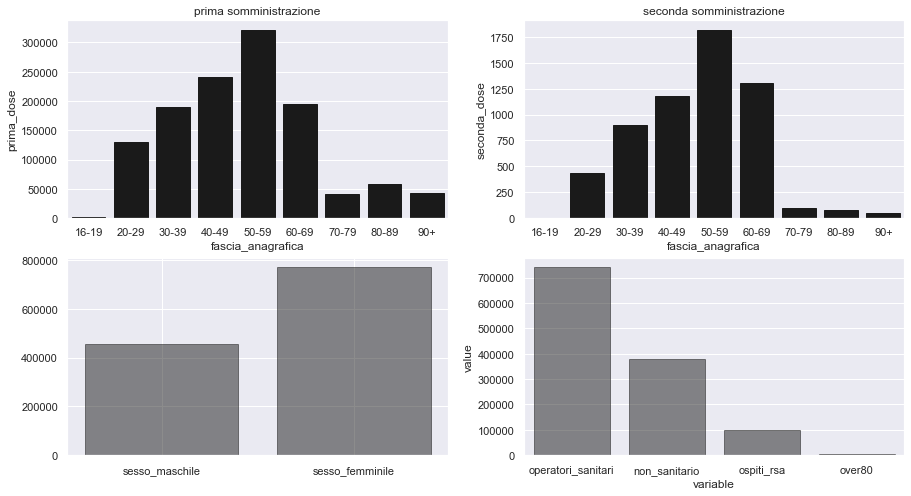

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

sns.barplot(
    data=smr, ax=ax[0,0],
    x='fascia_anagrafica', y='prima_dose',
    color='k', ec='k',
)
ax[0,0].set(
    title='prima somministrazione'
)
sns.barplot(
    data=smr, ax=ax[0,1],
    x='fascia_anagrafica', y='seconda_dose',
    color='k', ec='k',
)
ax[0,1].set(
    title='seconda somministrazione'
)

for y in ['maschile', 'femminile']:
    ax[1,0].bar(f'sesso_{y}', smr.sum()[f'sesso_{y}'], color='k', alpha=.5, ec='k')

g = sns.barplot(
    data=smr_cat,
    x='variable',
    y='value',
    color='k', ec='k',
    alpha=.5,
    ax=ax[1,1]
)
#g.axes.tick_params(axis='x', labelrotation=23)

#for y in ['prima_dose', 'seconda_dose']:
#    ax[1,1].bar(y, smr.sum()[y], color='k', ec='k')

_ = """
g = sns.barplot(
    data=reg,
    x='regione',
    y='somministrazioni',
    color='k', ec='k',
    ax=ax[1,1]
)

fig.suptitle(
    f"Vaccinazioni per COVID-19 in Italia, aggiornamento {sex.aggiornamento.max()}",
    fontsize=20,
)"""

plt.show()

In [11]:
reg_ts = pd.read_csv(
    'https://github.com/ondata/covid19italia/raw/master/webservices/vaccini/processing/somministrazioni.csv',
    parse_dates=['aggiornamento']
)

it_ts = reg_ts.groupby('aggiornamento')[['somministrazioni']].sum()
it_ts.loc[pd.to_datetime('2020-12-28'), 'somministrazioni'] = 0
it_ts.loc[pd.to_datetime('2020-12-29'), 'somministrazioni'] = 8361
it_ts.loc[pd.to_datetime('2020-12-30'), 'somministrazioni'] = 9803
it_ts.loc[pd.to_datetime('2020-12-31'), 'somministrazioni'] = 22789
it_ts.loc[pd.to_datetime('2021-01-01'), 'somministrazioni'] = 45667

for regione in reg_ts.regione.unique():
    reg_ts = reg_ts.append(
        pd.DataFrame({
            'regione': [regione],
            'somministrazioni': [0],
            'percentuale': [0.0],
            'dosiConsegnate': [0],
            'aggiornamento': [pd.to_datetime('2020-12-28')]
        })
    )
it_ts.sort_index(inplace=True)

In [12]:
it_ts_day = it_ts.resample('D').max()

# Totali

In [62]:
popolazione_italia = pop[pop.regione=='Italia'].popolazione.values[0]

In [63]:
pop_it = popolazione_italia - tot

In [64]:
Markdown(fr"""
Popolazione italiana maggiore di 16 anni (al 1° gennaio 2020, dati ISTAT)

$$
\mathbf{{pop}}_{{it}} = {f"{popolazione_italia:,}".replace(",", "'")} \textrm{{ persone}}
$$

definendo i soggetti suscettibili **S**
escludendo i casi totali di COVID-19 osservati finora

$$
\mathbf{{S}}_{{it}} = \mathbf{{pop}}_{{it}} - \mathbf{{COVID}}_{{it}} =
{f"{popolazione_italia:,}".replace(",", "'")} - {f"{tot:,}".replace(",", "'")} = 
{f"{pop_it:,}".replace(",", "'")} \textrm{{ persone}}
$$
""")


Popolazione italiana maggiore di 16 anni (al 1° gennaio 2020, dati ISTAT)

$$
\mathbf{pop}_{it} = 51'341'724 \textrm{ persone}
$$

definendo i soggetti suscettibili **S**
escludendo i casi totali di COVID-19 osservati finora

$$
\mathbf{S}_{it} = \mathbf{pop}_{it} - \mathbf{COVID}_{it} =
51'341'724 - 2'400'598 = 
48'941'126 \textrm{ persone}
$$


In [71]:
E = .95
R0 = 3
HIT = 1 - 1 / R0
V = HIT / E
V_it = V * pop_it
HIT_it = HIT * pop_it
VAX = smr.sum().seconda_dose
VAX_pct = VAX / pop_it

Markdown(fr"""
Soglia immunità di gregge **HIT** per COVID-19, considerando
$R_0={R0}$

$$
\mathbf{{HIT}} = 1 - \frac{{1}}{{R_0}} = {HIT * 100:.0f}\%
$$

Soglia considerando la popolazione suscettibile dai 16 anni

$$
\mathbf{{HIT}}_{{it}} = \mathbf{{HIT}} \cdot \mathbf{{S}}_{{it}} = 
{f"{HIT_it:,.0f}".replace(",", "'")} \textrm{{ abitanti}}
$$

Data l'efficacia vaccinale **E** del {E:.0%}
la minima copertura vaccinale **V** da raggiungere
è pari a

$$
\mathbf{{V}} = \frac{{ \mathbf{{HIT}} }}{{ \mathbf{{E}} }} = 
\frac{{{HIT:.2f}}}{{{E:.2f}}} = {V*100:.0f}\%
$$

pertanto, la minima copertura vaccinale per immunità di gregge in italia considerando
l'efficacia vaccinale risulta

$$
\mathbf{{V}}_{{it}} = \mathbf{{V}} \cdot \mathbf{{S}}_{{it}} = 
{f"{V_it:,.0f}".replace(",", "'")} \textrm{{ abitanti}}
$$

***

Attuale numero di vaccini completi somministrati (seconda dose)

$$
\mathbf{{VAX}} = {f"{VAX:,.0f}".replace(",", "'")} \textrm{{ vaccini}}
$$

Attuale percentuale raggiunta (rispetto a popolazione suscettibile definita)

$$
\mathbf{{VAX}}\% = \frac{{ \mathbf{{VAX}} }}{{ \mathbf{{S}}_{{it}} }} =
{VAX_pct * 100:.2f}\%
$$""")


Soglia immunità di gregge **HIT** per COVID-19, considerando
$R_0=3$

$$
\mathbf{HIT} = 1 - \frac{1}{R_0} = 67\%
$$

Soglia considerando la popolazione suscettibile dai 16 anni

$$
\mathbf{HIT}_{it} = \mathbf{HIT} \cdot \mathbf{S}_{it} = 
32'627'417 \textrm{ abitanti}
$$

Data l'efficacia vaccinale **E** del 95%
la minima copertura vaccinale **V** da raggiungere
è pari a

$$
\mathbf{V} = \frac{ \mathbf{HIT} }{ \mathbf{E} } = 
\frac{0.67}{0.95} = 70\%
$$

pertanto, la minima copertura vaccinale per immunità di gregge in italia considerando
l'efficacia vaccinale risulta

$$
\mathbf{V}_{it} = \mathbf{V} \cdot \mathbf{S}_{it} = 
34'344'650 \textrm{ abitanti}
$$

***

Attuale numero di vaccini completi somministrati (seconda dose)

$$
\mathbf{VAX} = 5'864 \textrm{ vaccini}
$$

Attuale percentuale raggiunta (rispetto a popolazione suscettibile definita)

$$
\mathbf{VAX}\% = \frac{ \mathbf{VAX} }{ \mathbf{S}_{it} } =
0.01\%
$$

In [77]:
vax_ts = pd.read_csv(
    'https://github.com/italia/covid19-opendata-vaccini/raw/master/dati/somministrazioni-vaccini-latest.csv',
    parse_dates=['data_somministrazione']
)

In [78]:
it_ts = vax_ts.groupby('data_somministrazione').sum()

In [109]:
vax_Y = it_ts.cumsum()[-7:].seconda_dose.values.ravel()
vax_X = np.arange(vax_Y.size)
vax_X = sm.add_constant(vax_X)
mod = sm.OLS(vax_Y, vax_X)
res = mod.fit()
VAX_n = res.params[1]
vax_i = res.params[0]

In [110]:
VAX_pred = vax_i + np.arange(14) * VAX_n

In [111]:
pred_dates = pd.date_range(
    it_ts.index[-6].date(),
    it_ts.index[-6] + pd.Timedelta(days=13),
)

In [112]:
HIT_rem = V_it - VAX

In [113]:
REM_d = HIT_rem / VAX_n

> **NOTA BENE**: la seguente stima sarà attendibile nel momento in cui la somministrazione delle seconde dosi sarà a pieno regime.

In [114]:
Markdown(fr"""
Vaccini somministrati mediamente al giorno $n$ nell'ultima settimana
(regressione lineare)

$$
\mathbf{{VAX}}_{{n}} = \frac{{\mathbf{{VAX}}}}{{\mathrm{{giorni}}}} \simeq 
{f"{VAX_n:,.0f}".replace(",", "'")} 
\textrm{{ vaccini al giorno }}
$$

Vaccini restanti da somministrare per raggiungere la soglia **V**
(**HIT** considerando l'efficacia vaccinale **E**)

$$
\mathbf{{VAX}}_{{rem}} = \mathbf{{V}}_{{it}} - \mathbf{{VAX}} = 
{f"{HIT_rem:,.0f}".replace(",", "'")}
\textrm{{ abitanti}}
$$

Tempo stimato per raggiungimento della soglia vaccinale **V** al ritmo 
di somministrazione attuale

$$
\mathbf{{T}}_{{rem}} = \frac{{\mathbf{{VAX}}_{{rem}}}}{{\mathbf{{VAX}}_{{n}}}} =
{f"{REM_d:,.0f}".replace(",", "'")} \textrm{{ giorni}}
= {REM_d/365*12:,.0f} \textrm{{ mesi}}
= {REM_d/365:,.1f} \textrm{{ anni}}
$$
""")


Vaccini somministrati mediamente al giorno $n$ nell'ultima settimana
(regressione lineare)

$$
\mathbf{VAX}_{n} = \frac{\mathbf{VAX}}{\mathrm{giorni}} \simeq 
974 
\textrm{ vaccini al giorno }
$$

Vaccini restanti da somministrare per raggiungere la soglia **V**
(**HIT** considerando l'efficacia vaccinale **E**)

$$
\mathbf{VAX}_{rem} = \mathbf{V}_{it} - \mathbf{VAX} = 
34'338'786
\textrm{ abitanti}
$$

Tempo stimato per raggiungimento della soglia vaccinale **V** al ritmo 
di somministrazione attuale

$$
\mathbf{T}_{rem} = \frac{\mathbf{VAX}_{rem}}{\mathbf{VAX}_{n}} =
35'262 \textrm{ giorni}
= 1,159 \textrm{ mesi}
= 96.6 \textrm{ anni}
$$


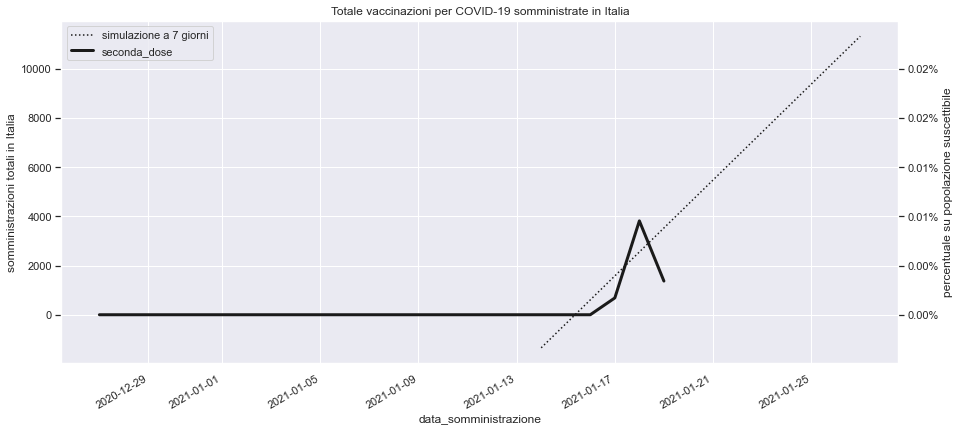

In [115]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True)
ax.plot(pred_dates, VAX_pred, ls=':', color='k', label='simulazione a 7 giorni')
it_ts.plot(
    y='seconda_dose',
    title='Totale vaccinazioni per COVID-19 somministrate in Italia',
    #marker='.', 
    color='k', lw=3,
    legend=False,
    ax=ax
)

ax.set(
    ylabel='somministrazioni totali in Italia',
)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set(
    yticks=ax1.get_yticks(),
    yticklabels=[f"{p:.2%}" for p in ax1.get_yticks() / pop_it],
    ylabel='percentuale su popolazione suscettibile'
)
ax1.set_ylim(ax.get_ylim())
ax1.grid(alpha=0)

ax.legend()

plt.show()

In [118]:
HIT_pred_dates = pd.date_range(
    it_ts.index[-6],
    it_ts.index[-6] + pd.Timedelta(days=REM_d+6),
)

In [119]:
HIT_pred = vax_i + VAX_n * np.arange(HIT_pred_dates.size)

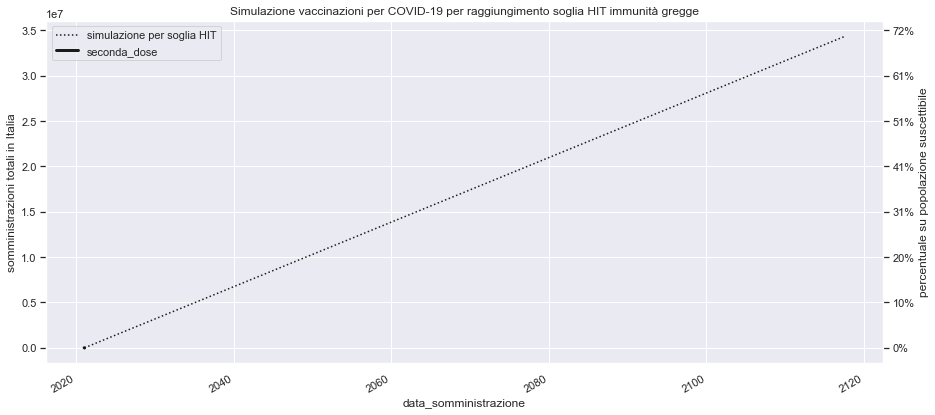

In [121]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True)
ax.plot(HIT_pred_dates, HIT_pred, ls=':', color='k', label='simulazione per soglia HIT')
it_ts.plot(
    y='seconda_dose',
    title='Simulazione vaccinazioni per COVID-19 per raggiungimento soglia HIT immunità gregge',
    #marker='.', 
    color='k', lw=3,
    legend=False,
    ax=ax
)

ax.set(
    ylabel='somministrazioni totali in Italia',
)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set(
    yticks=ax1.get_yticks(),
    yticklabels=[f"{p:.0%}" for p in ax1.get_yticks() / pop_it],
    ylabel='percentuale su popolazione suscettibile'
)
ax1.set_ylim(ax.get_ylim())
ax1.grid(alpha=0)

ax.legend()

plt.show()

# Regioni

In [122]:
pop.regione = pop.regione.str.replace("Valle d'Aosta / Vallée d'Aoste", "Valle d'Aosta")

In [123]:
pop.regione = pop.regione.str.replace("Provincia Autonoma Bolzano / Bozen", "P.A. Bolzano")

In [124]:
pop.regione = pop.regione.str.replace("Provincia Autonoma Trento", "P.A. Trento")

In [125]:
pop.regione = pop.regione.str.replace("Friuli-Venezia Giulia", "Friuli-Venezia-Giulia")

In [136]:
iss_to_name = {}
nomi = pop.regione[1:].sort_values().values
for i, codice in enumerate(vax_ts.area.unique()):
    iss_to_name.update({codice: nomi[i]})

In [140]:
vax_ts['regione'] = vax_ts.area.map(iss_to_name)

In [177]:
vax_cum = None
for regione in vax_ts.regione.unique():
    _df = vax_ts[vax_ts.regione==regione]
    _df_sum = _df.groupby('data_somministrazione').sum().cumsum()
    #_df_reg = _df.iloc[:,:4].merge(_df_sum, left_index=True, right_index=True)
    _df_sum['regione'] = regione
    if vax_cum is None:
        vax_cum = _df_sum
    else:
        vax_cum = vax_cum.append(_df_sum)
#[['data_somministrazione', 'prima_dose', 'seconda_dose', 'regione']]
    

In [181]:
reg = vax_cum.reset_index().merge(
    pop,
    on='regione'
)

In [183]:
reg['percentuale prima_dose'] = reg.prima_dose / reg.popolazione
reg['percentuale seconda_dose'] = reg.seconda_dose / reg.popolazione

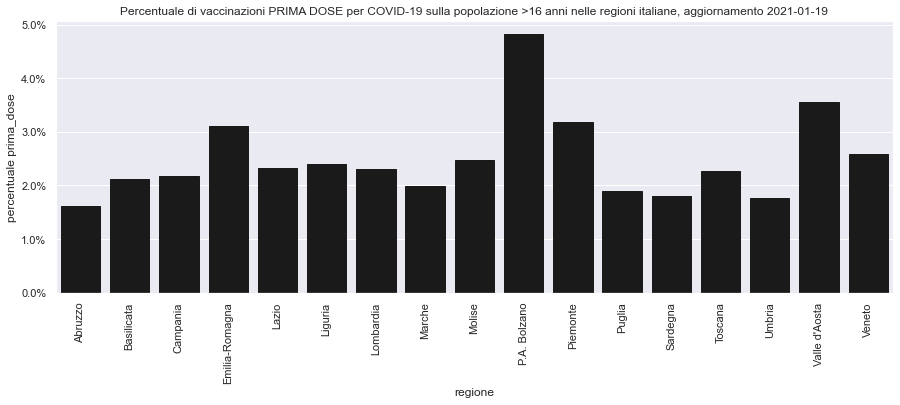

In [188]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data=reg[reg.data_somministrazione==reg.data_somministrazione.max()],
    x='regione',
    y='percentuale prima_dose',
    color='k', ec='k',
    ax=ax
)
ax.tick_params(axis='x', labelrotation=90)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
ax.set(
    title=f"Percentuale di vaccinazioni PRIMA DOSE per COVID-19 sulla popolazione >16 anni nelle regioni italiane, aggiornamento {reg.data_somministrazione.max().date()}",
)
plt.show()

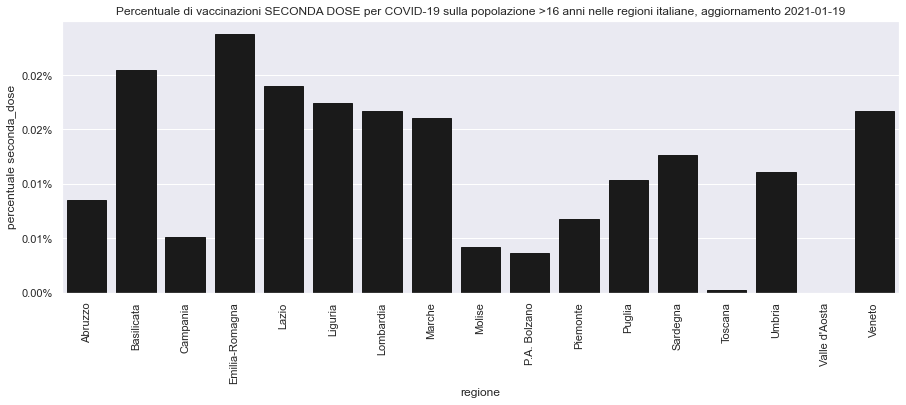

In [190]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data=reg[reg.data_somministrazione==reg.data_somministrazione.max()],
    x='regione',
    y='percentuale seconda_dose',
    color='k', ec='k',
    ax=ax
)
ax.tick_params(axis='x', labelrotation=90)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
ax.set(
    title=f"Percentuale di vaccinazioni SECONDA DOSE per COVID-19 sulla popolazione >16 anni nelle regioni italiane, aggiornamento {reg.data_somministrazione.max().date()}",
)
plt.show()

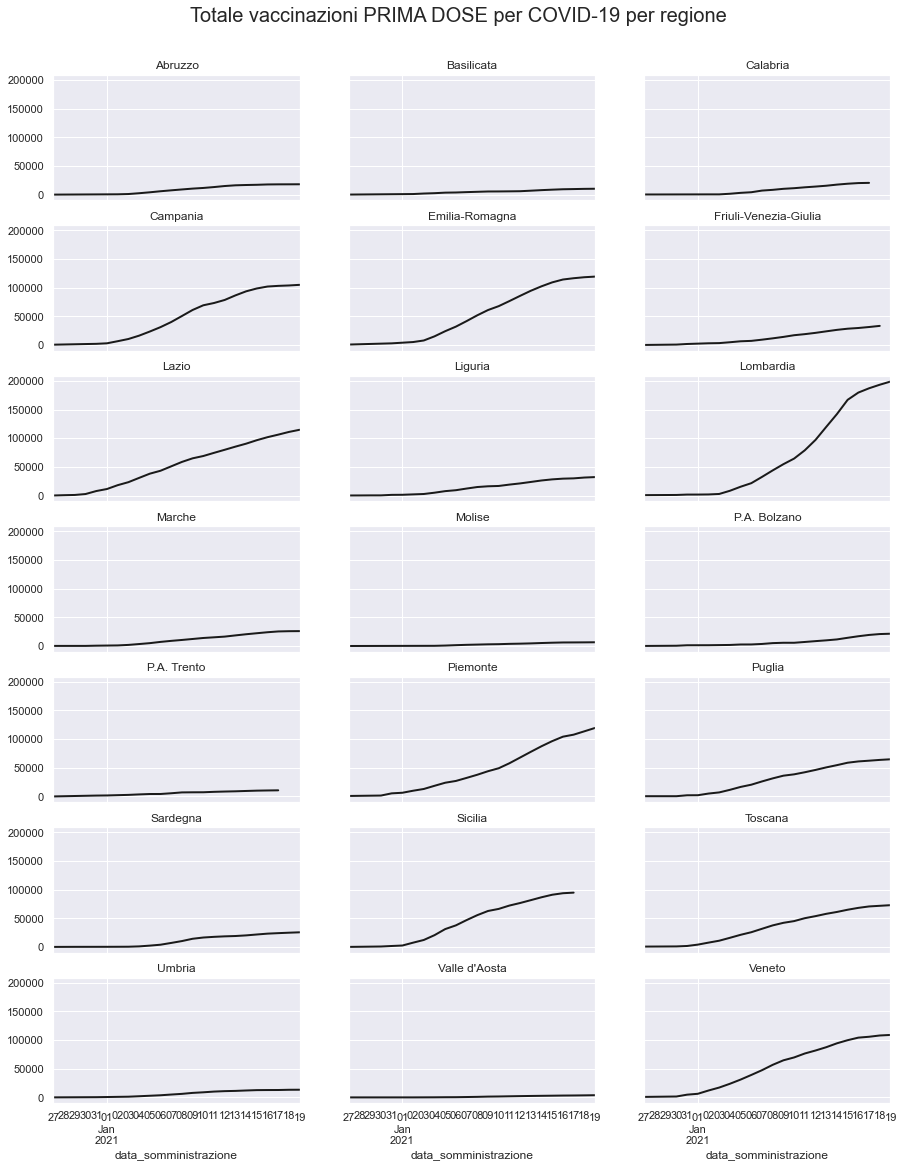

In [193]:
fig, ax = plt.subplots(7, 3, figsize=(15, 7*3), sharex=True, sharey=True)
for i, regione in enumerate(reg.regione.unique()):
    _ts = reg[reg.regione==regione]
    _ts.plot(
        x='data_somministrazione', y='prima_dose', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, legend=False,
        title=f'{regione}'
    )
fig.suptitle("Totale vaccinazioni PRIMA DOSE per COVID-19 per regione", fontsize=20, y=.925)
plt.show()

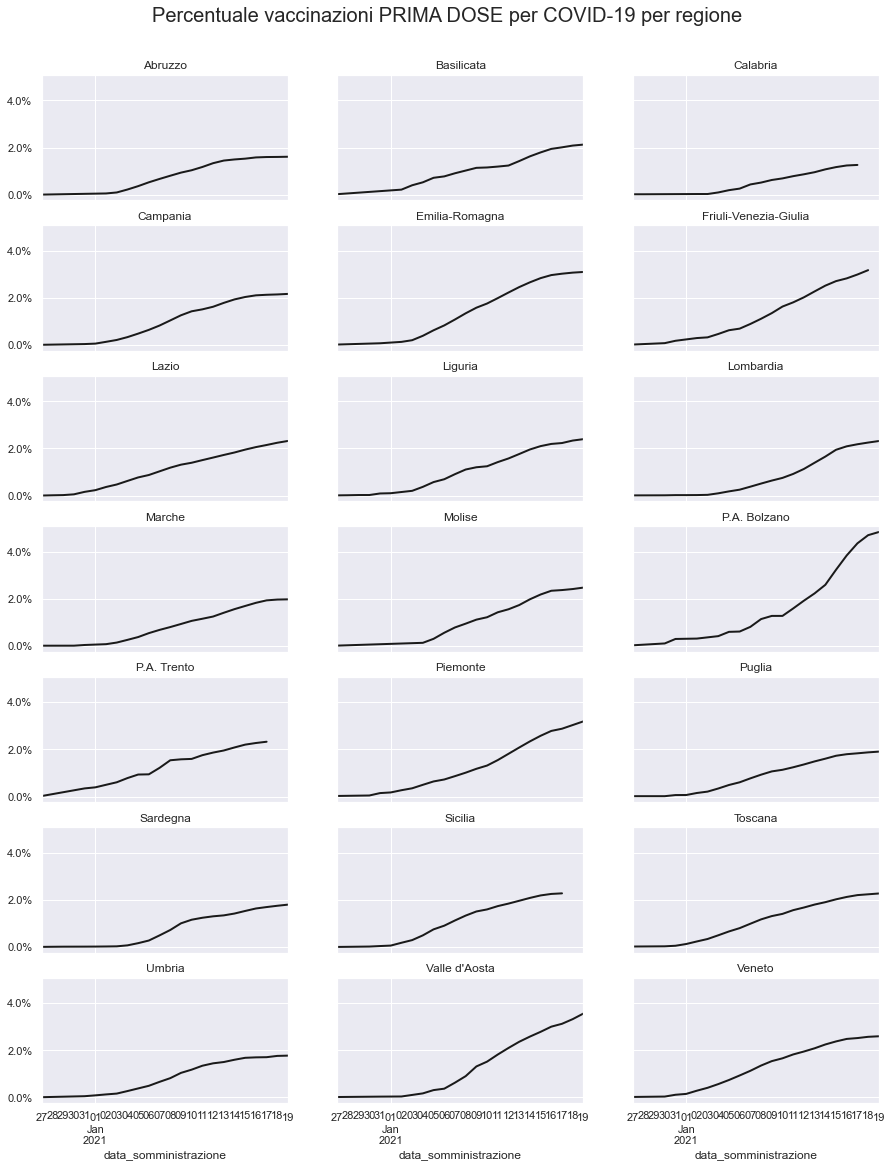

In [196]:
fig, ax = plt.subplots(7, 3, figsize=(15, 7*3), sharex=True, sharey=True)
for i, regione in enumerate(reg.regione.unique()):
    _ts = reg[reg.regione==regione]
    _ts.plot(
        x='data_somministrazione', y='percentuale prima_dose', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, legend=False,
        title=f'{regione}'
    )
    ax.flat[i].yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
fig.suptitle("Percentuale vaccinazioni PRIMA DOSE per COVID-19 per regione", fontsize=20, y=.925)
plt.show()

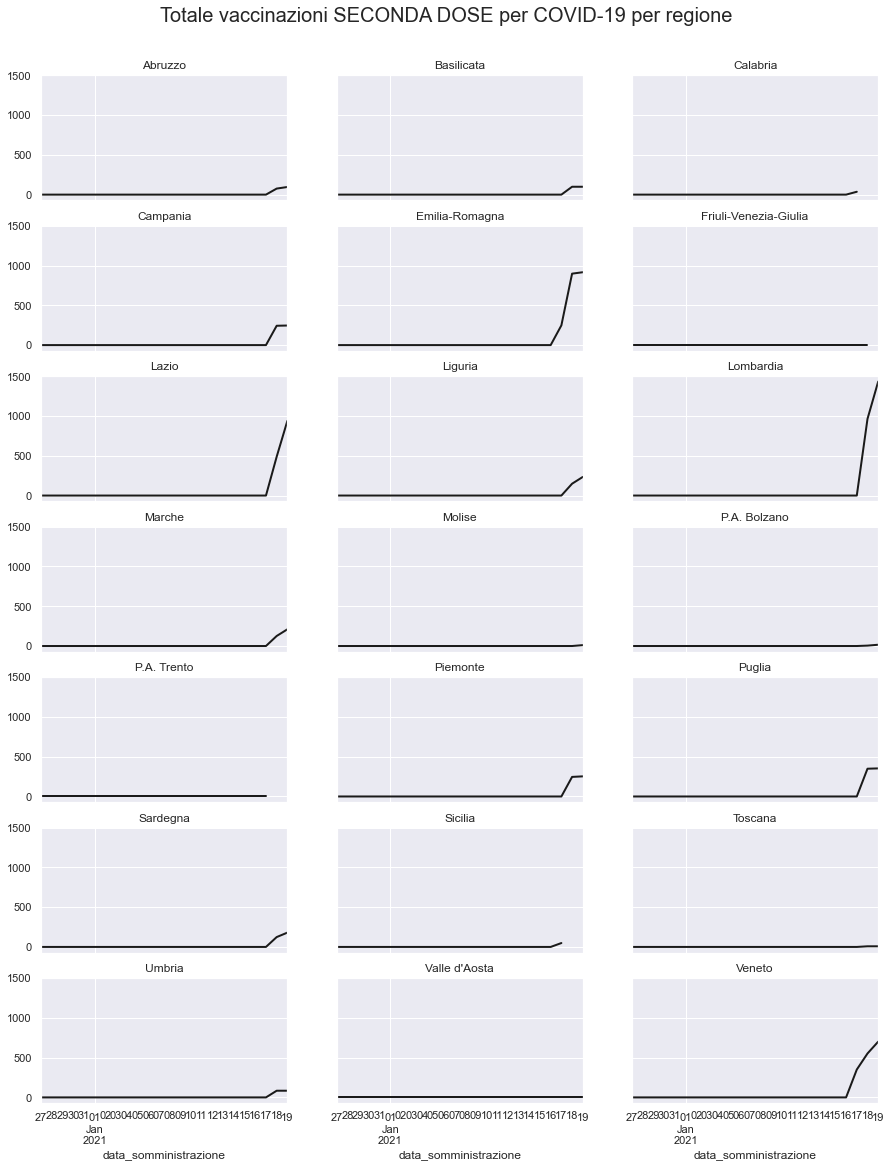

In [194]:
fig, ax = plt.subplots(7, 3, figsize=(15, 7*3), sharex=True, sharey=True)
for i, regione in enumerate(reg.regione.unique()):
    _ts = reg[reg.regione==regione]
    _ts.plot(
        x='data_somministrazione', y='seconda_dose', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, legend=False,
        title=f'{regione}'
    )
fig.suptitle("Totale vaccinazioni SECONDA DOSE per COVID-19 per regione", fontsize=20, y=.925)
plt.show()

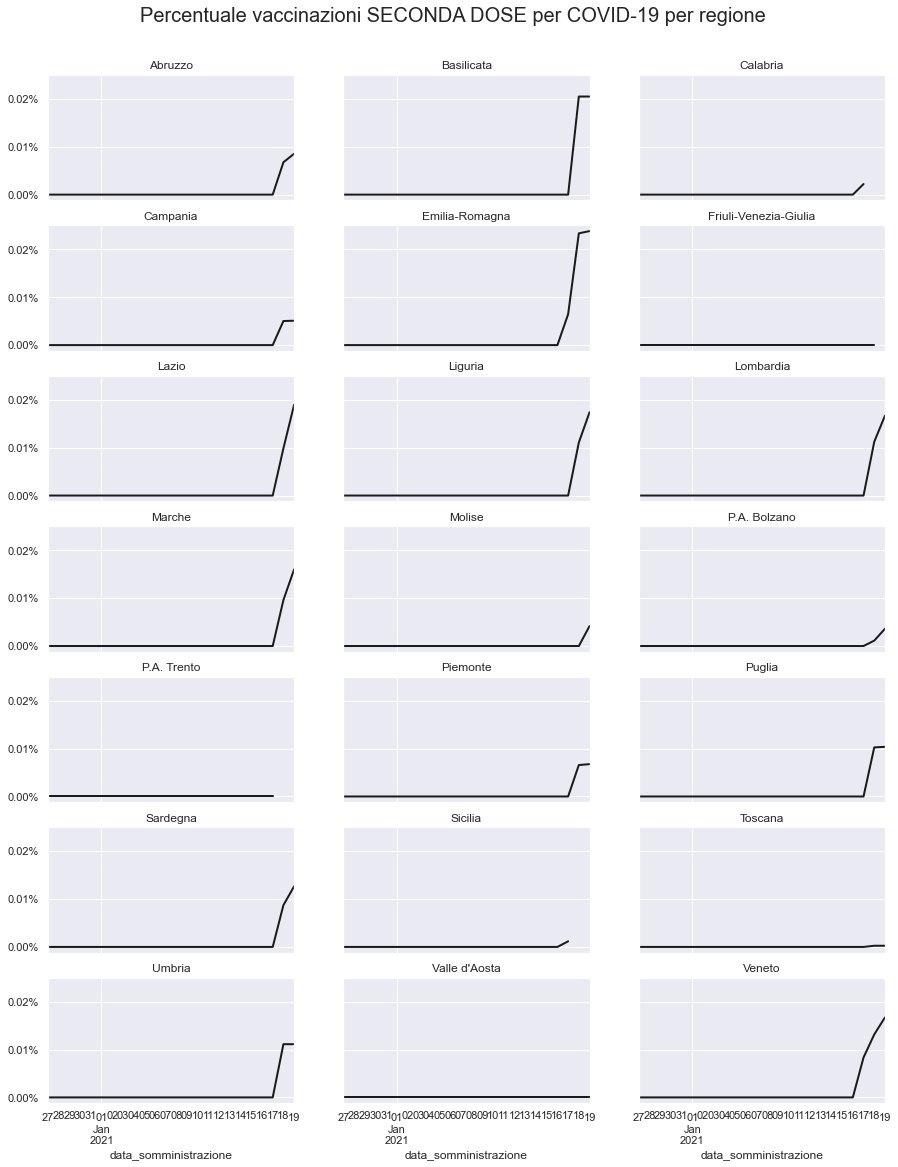

In [198]:
fig, ax = plt.subplots(7, 3, figsize=(15, 7*3), sharex=True, sharey=True)
for i, regione in enumerate(reg.regione.unique()):
    _ts = reg[reg.regione==regione]
    _ts.plot(
        x='data_somministrazione', y='percentuale seconda_dose', ax=ax.flat[i], 
        color='k', 
        #marker='.', 
        lw=2, legend=False,
        title=f'{regione}'
    )
    ax.flat[i].yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
fig.suptitle("Percentuale vaccinazioni SECONDA DOSE per COVID-19 per regione", fontsize=20, y=.925)
plt.show()